In [2]:
!python -V

Python 3.12.3


In [3]:
import pandas as pd

In [4]:
import pickle

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [20]:
import mlflow

In [21]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")

In [22]:
mlflow.set_experiment("nyc_taxi_trip")

2024/05/21 15:12:42 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/05/21 15:12:42 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/home/mlops_zoomcamp/mlops/module_2/mlruns/1', creation_time=1716304363012, experiment_id='1', last_update_time=1716304363012, lifecycle_stage='active', name='nyc_taxi_trip', tags={}>

In [23]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [24]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/home/mlops_zoomcamp/miniconda3/envs/exp-tracker/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.838799799829626

/tmp/ipykernel_2019/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_2019/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


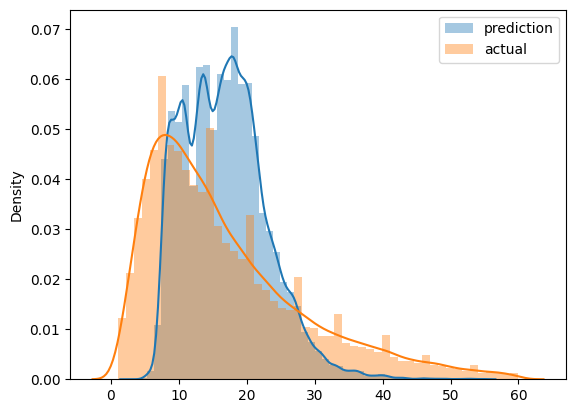

In [25]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [26]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [27]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [28]:
len(df_train), len(df_val)

(73908, 61921)

In [29]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [30]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [31]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/mlops_zoomcamp/miniconda3/envs/exp-tracker/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.758715208009878

In [33]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

/home/mlops_zoomcamp/miniconda3/envs/exp-tracker/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


11.167275941179728

In [38]:
with mlflow.start_run():
    mlflow.set_tag("developer","kailash")
    mlflow.log_param("train-data-path","./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path","./data/green_tripdata_2021-02.parquet")

    
    alpha = 0.1
    mlflow.log_param("alpha",alpha)
    lr = Lasso(0.01)
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_val)
    
    rmse=mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse",rmse)
        

/home/mlops_zoomcamp/miniconda3/envs/exp-tracker/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [39]:
import xgboost as xgb

In [40]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [41]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [42]:


def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}



In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|                                                             | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/mlops_zoomcamp/miniconda3/envs/exp-tracker/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [17:03:51] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.02130                                                                             
[1]	validation-rmse:8.63347                                                                              
[2]	validation-rmse:7.78604                                                                              
[3]	validation-rmse:7.27988                                                                              
[4]	validation-rmse:6.98213                                                                              
[5]	validation-rmse:6.80033                                                                              
[6]	validation-rmse:6.68974                                                                              
[7]	validation-rmse:6.62317                                                                              
[8]	validation-rmse:6.57670                                                                              
[9]	validation-rmse:6.54402                   

/home/mlops_zoomcamp/miniconda3/envs/exp-tracker/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/mlops_zoomcamp/miniconda3/envs/exp-tracker/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [17:05:52] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.28074                                                                             
[1]	validation-rmse:10.49244                                                                             
[2]	validation-rmse:9.82613                                                                              
[3]	validation-rmse:9.26702                                                                              
[4]	validation-rmse:8.80305                                                                              
[5]	validation-rmse:8.41809                                                                              
[6]	validation-rmse:8.09831                                                                              
[7]	validation-rmse:7.83451                                                                              
[8]	validation-rmse:7.61616                                                                              
[9]	validation-rmse:7.43138                   

/home/mlops_zoomcamp/miniconda3/envs/exp-tracker/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/mlops_zoomcamp/miniconda3/envs/exp-tracker/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [17:10:30] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.10493                                                                              
[1]	validation-rmse:6.57663                                                                              
[2]	validation-rmse:6.50372                                                                              
[3]	validation-rmse:6.48536                                                                              
[4]	validation-rmse:6.47527                                                                              
[5]	validation-rmse:6.47117                                                                              
[6]	validation-rmse:6.46263                                                                              
[7]	validation-rmse:6.45487                                                                              
[8]	validation-rmse:6.44934                                                                              
[9]	validation-rmse:6.44100                   

/home/mlops_zoomcamp/miniconda3/envs/exp-tracker/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/mlops_zoomcamp/miniconda3/envs/exp-tracker/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [17:11:19] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.36165                                                                              
[1]	validation-rmse:7.15337                                                                              
[2]	validation-rmse:6.78808                                                                              
[3]	validation-rmse:6.67540                                                                              
[4]	validation-rmse:6.62330                                                                              
[5]	validation-rmse:6.60071                                                                              
[6]	validation-rmse:6.59104                                                                              
[7]	validation-rmse:6.58203                                                                              
[8]	validation-rmse:6.57634                                                                              
[9]	validation-rmse:6.56999                   

/home/mlops_zoomcamp/miniconda3/envs/exp-tracker/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/mlops_zoomcamp/miniconda3/envs/exp-tracker/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [17:12:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.37926                                                                             
[1]	validation-rmse:10.65703                                                                             
[2]	validation-rmse:10.03391                                                                             
[3]	validation-rmse:9.49802                                                                              
[4]	validation-rmse:9.03958                                                                              
[5]	validation-rmse:8.64870                                                                              
[6]	validation-rmse:8.31745                                                                              
[7]	validation-rmse:8.03677                                                                              
[8]	validation-rmse:7.79914                                                                              
[9]	validation-rmse:7.59918                   

/home/mlops_zoomcamp/miniconda3/envs/exp-tracker/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/mlops_zoomcamp/miniconda3/envs/exp-tracker/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [17:18:19] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.98080                                                                              
[1]	validation-rmse:8.59989                                                                              
[2]	validation-rmse:7.78314                                                                              
[3]	validation-rmse:7.30989                                                                              
[4]	validation-rmse:7.03682                                                                              
[5]	validation-rmse:6.87713                                                                              
[6]	validation-rmse:6.78028                                                                              
[7]	validation-rmse:6.71805                                                                              
[8]	validation-rmse:6.68158                                                                              
[9]	validation-rmse:6.65661                   

/home/mlops_zoomcamp/miniconda3/envs/exp-tracker/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/mlops_zoomcamp/miniconda3/envs/exp-tracker/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [17:20:28] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.48203                                                                             
[1]	validation-rmse:10.83508                                                                             
[2]	validation-rmse:10.26509                                                                             
[3]	validation-rmse:9.76592                                                                              
[4]	validation-rmse:9.32713                                                                              
[5]	validation-rmse:8.94295                                                                              
[6]	validation-rmse:8.60828                                                                              
[7]	validation-rmse:8.31921                                                                              
[8]	validation-rmse:8.07019                                                                              
[9]	validation-rmse:7.85243                   

/home/mlops_zoomcamp/miniconda3/envs/exp-tracker/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/mlops_zoomcamp/miniconda3/envs/exp-tracker/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [17:25:51] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.43047                                                                              
[1]	validation-rmse:7.23259                                                                              
[2]	validation-rmse:6.88578                                                                              
[3]	validation-rmse:6.77137                                                                              
[4]	validation-rmse:6.72414                                                                              
[5]	validation-rmse:6.70339                                                                              
[6]	validation-rmse:6.69047                                                                              
[7]	validation-rmse:6.68699                                                                              
[8]	validation-rmse:6.68269                                                                              
[9]	validation-rmse:6.68027                   

/home/mlops_zoomcamp/miniconda3/envs/exp-tracker/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/mlops_zoomcamp/miniconda3/envs/exp-tracker/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [17:27:26] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.01196                                                                              
[1]	validation-rmse:7.59053                                                                              
[2]	validation-rmse:7.00417                                                                              
[3]	validation-rmse:6.75911                                                                              
[4]	validation-rmse:6.65100                                                                              
[5]	validation-rmse:6.59822                                                                              
[6]	validation-rmse:6.56326                                                                              
[7]	validation-rmse:6.54485                                                                              
[8]	validation-rmse:6.52792                                                                              
[9]	validation-rmse:6.51629                   

/home/mlops_zoomcamp/miniconda3/envs/exp-tracker/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/mlops_zoomcamp/miniconda3/envs/exp-tracker/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [17:28:37] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.40725                                                                             
[1]	validation-rmse:10.70864                                                                             
[2]	validation-rmse:10.10564                                                                             
[3]	validation-rmse:9.58723                                                                              
[4]	validation-rmse:9.14345                                                                              
[5]	validation-rmse:8.76526                                                                              
[6]	validation-rmse:8.44412                                                                              
[7]	validation-rmse:8.17220                                                                              
[8]	validation-rmse:7.94317                                                                              
[9]	validation-rmse:7.74911                   

In [ ]:
mlflow.xgboost.autolog(disable=True)

In [ ]:
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")